In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tabulate import tabulate
import pandas as pd

C:\Users\Jhirs\AppData\Local\Temp\ipykernel_10620\574224501.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
names = ['Sex', 'Length (mm)', 'Diameter (mm)', 'Height (mm)', 'Whole Weight (g)',
                'Shucked Weight (g)', 'Viscera Weight (g)', 'Shell Weight (g)', 'Rings']
df = pd.read_csv("https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/abalone.original.csv", names=names)

We can start our modeling with a baseline model for Rings. Remember for our single variable EDA, we saw a roughly symmetric histogram. We can start by describing the loss function that we want. We would want to penalize underestimates and overestimates the same amount, and penalize large errors more than small errors. This leads us to the Mean Squared Error as our loss function. We might then be able to use the mean as a baseline model. Here are the descriptive statistics once again:

In [3]:
df['Rings'].describe()

count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: Rings, dtype: float64

So we predict an abalone will have 10 Rings (rounding since rings should be an integer, not floating point decimal). We can then create 95% error bounds. Since we know the data is roughly symmetric, we can use standard deviation to find the bounds as ($\hat{y}$ - 1.96 * s, $\hat{y}$ + 1.96 * s), where $\hat{y}$ is the predictive value for the model/mean (using $\bar{y}$ - the actual mean), and s is the standard deviation.

In [6]:
rings_mean = np.mean(df['Rings'])
rings_std = np.std(df['Rings'])

lower = rings_mean - 1.96 * rings_std
upper = rings_mean + 1.96 * rings_std

print(f'({lower}, {upper})')

(3.615069653523343, 16.252299271542494)


There is a 95% chance the Rings that an abalone has is between 3.6 and 16.2.

Now we can move on to the data generating story. It seems that the age of an abalone has many different factors, from diet, to genetics, to temperature and salinity of water. I believe these are all small additive effects, and as such it would be appropriate to think that Rings might follow an approximate Gaussian distribution. We also note that the value for Rings cannot be negative or nonzero (the min is 1, as a reminder).

We know the parameters for the Gaussian distribution are the mean and standard deviation. We can estimate the mean ($\mu$) as our mean $\bar{y}$ and our standard deviation ($\sigma$) as _s_ using methods of moments estimators and the values we calculated above.

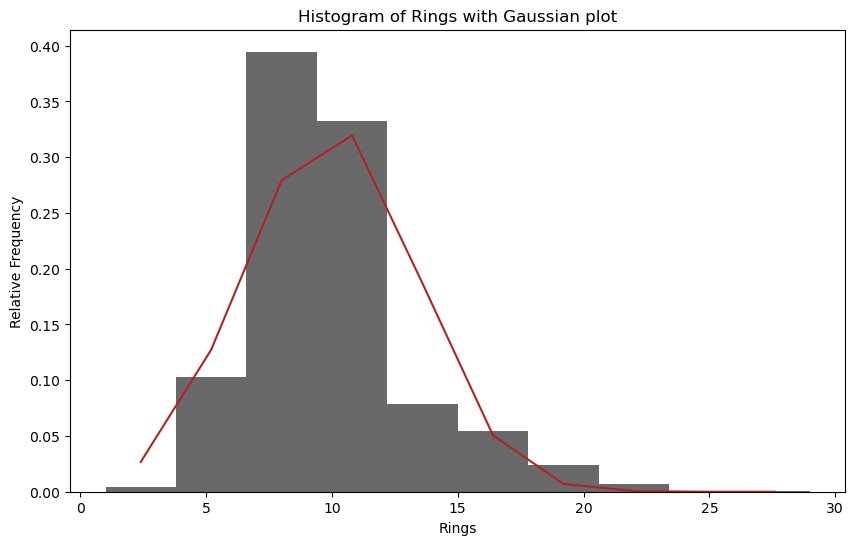

In [7]:
fig = plt.figure(figsize=(10,6))

data = df['Rings']
mu = np.mean(data)
std = np.std(data)


axes = fig.add_subplot(1,1,1)
emp_weights = np.ones(len(data)) / len(data)
n, bins, patches = axes.hist(data, color='dimgray', weights=emp_weights)

axes.set_xlabel('Rings')
axes.set_ylabel('Relative Frequency')
axes.set_title('Histogram of Rings with Gaussian plot')

xs = [(b2+b1)/2 for b1, b2 in zip(bins, bins[1:])]

sampled_data = [mu + r*std for r in np.random.standard_normal(10000)]
samp_weights = np.ones(len(sampled_data)) / len(sampled_data)
vals, base = np.histogram(sampled_data, bins=bins, weights=samp_weights)
axes.plot(xs, vals, color='firebrick')

plt.show()
plt.close()

It appears that this model overestimates rings between about 12-15, and underestimates rings in the range of about 7-12. We can also look at a chart for the difference in cumulative mass between the empirical data and the distributional model. Note a lot of the code here follows from *Fundamentals* page 578-579.

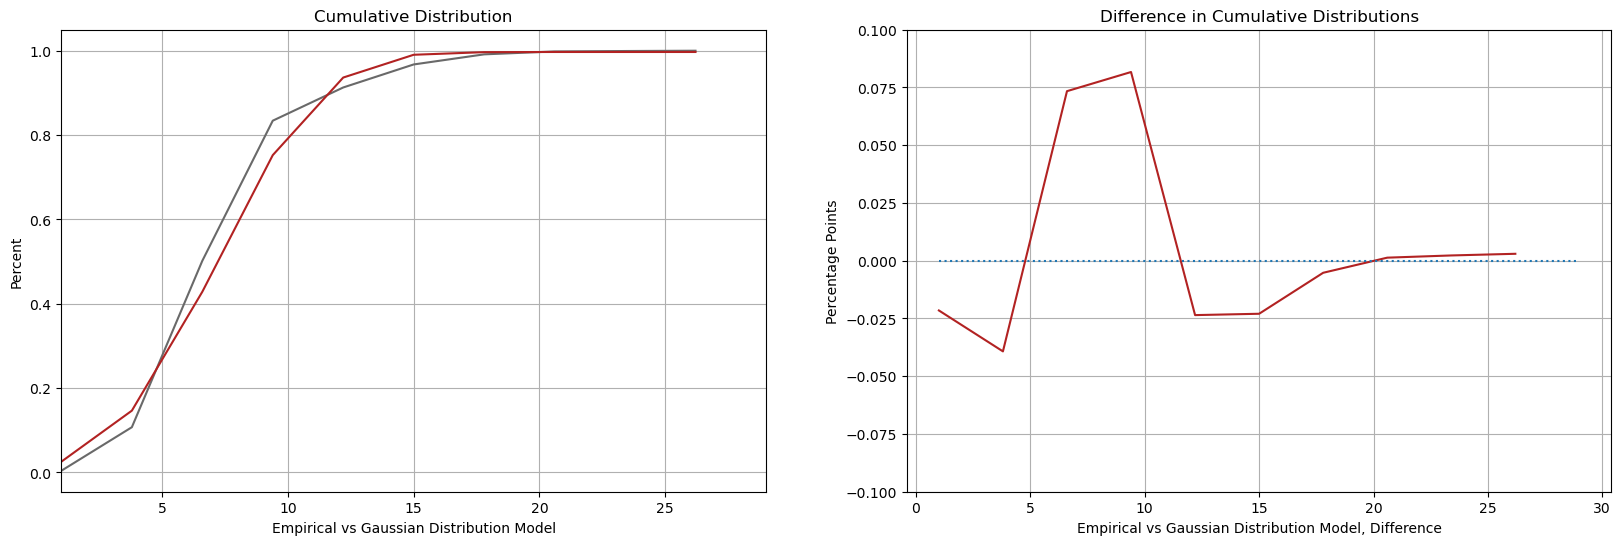

In [11]:
figure = plt.figure(figsize = (20,6))

data = df['Rings']
data_min = np.min(data)
data_max = np.max(data)
mu = np.mean(data)
std = np.std(data)

emp_weights = np.ones(len(data)) / len(data)
axes = figure.add_subplot(1,2,1)

vals, base = np.histogram(data, bins=10, weights=emp_weights)
cumulative = np.cumsum(vals)

axes.plot(base[:-1], cumulative, color='dimgray')
axes.set_xlim((data_min, data_max))

sampled_data = [mu + r*std for r in np.random.standard_normal(10000)]
samp_weights = np.ones(len(sampled_data)) / len(sampled_data)
vals2, base = np.histogram(sampled_data, bins=base, weights=samp_weights)
cumulative2 = np.cumsum(vals2)

axes.plot(base[:-1], cumulative2, color='firebrick')
axes.set_title('Cumulative Distribution')
axes.set_xlim((data_min, data_max))
axes.set_ylabel('Percent')
axes.set_xlabel('Empirical vs Gaussian Distribution Model')
axes.grid(axis='y')
axes.grid(axis='x')

axes = figure.add_subplot(1,2,2)
differences = cumulative - cumulative2
axes.plot(base[:-1], differences, color='firebrick')
axes.hlines(0, data_min, data_max, linestyles='dotted')
axes.set_ylim((-0.1,0.1))
axes.set_title('Difference in Cumulative Distributions')
axes.set_xlabel('Empirical vs Gaussian Distribution Model, Difference')
axes.set_ylabel('Percentage Points')
axes.grid(axis='y')
axes.grid(axis='x')

plt.show()
plt.close()


We see that the model underestimates close to 5 rings, overestimates around 7-11, and underestimates again around 12-15 rings. This is similar to what we saw in the histogram above as well.

Finally we can make a few predictions using this model. For the first prediction, let's predict the probability that a random abalone will have more than 18 rings (it would be at least 19.5-20 years old):

In [12]:
stats.norm.sf(18, rings_mean, rings_std)

0.006172476814940498

We see only about 0.6% chance a random abalone has 18 or more rings.

Next we can ask, what is the probability of finding a random abalone with 8-10 rings:

In [13]:
stats.norm.cdf(10, rings_mean, rings_std) - stats.norm.cdf(8, rings_mean, rings_std)

0.23389232282734262

About a 23% probability of observing an abalone that has between 8 and 10 rings.

Finally, what ring count or lower are we likely to see with 20% probability?

In [14]:
stats.norm.ppf([0.25], rings_mean, rings_std)

array([7.75927583])

We are likely to see an abalone with 7.7 (or roughly 8) or lower with 25% probability.

Note that the Gaussian distribution is reasonable at approximating continuous data, but Rings is a discrete variable. I feel that the data generating story led me to a Gaussian model however, as again we had small additive effects on how many rings an abalone has. We could have also tried a Poisson distribution, but the central limit theorem also leads me to believe that this distribution would tend towards the Gaussian. 